Name: Victor Olawale-Apanpa

DATE: 4 NOV 2025 (Using Joker)

 - Github Username: vapanpa
  - How to Run: Code separated into 2 Notebook Files
     - Cartpole
     - Packman

 Run as is to train and produce results.

# CartPole-v1

In [24]:
# cell 1
import os, json, math, random, datetime as dt
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gymnasium as gym

# --------- Repro & small helpers ---------
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def now_ts():
    return dt.datetime.now().strftime("%Y%m%d_%H%M%S")

def ensure_dir(p: Path | str):
    Path(p).mkdir(parents=True, exist_ok=True)

def moving_avg(x, k=100):
    # (kept for compatibility, but we won't use this for the figure)
    x = np.asarray(x, dtype=np.float32)
    if len(x) == 0:
        return x
    w = min(k, len(x))
    ma = np.convolve(x, np.ones(w)/w, mode="same")
    return ma

def trailing_ma(x, k=100):
    """Trailing moving average over the LAST k episodes (no centering)."""
    x = np.asarray(x, np.float32)
    out = np.empty_like(x)
    s = 0.0
    q = []
    for i, v in enumerate(x):
        q.append(float(v)); s += float(v)
        if len(q) > k:
            s -= q.pop(0)
        out[i] = s / len(q)
    return out

set_seed(42)
device = torch.device("cpu")  # CPU per assignment constraint for you right now
print("Device:", device)

Device: cpu


In [25]:
# cell 2
class QNetworkMLP(nn.Module):
    """Simple MLP for low-dimensional observations (e.g., CartPole)."""
    def __init__(self, obs_dim: int, n_actions: int, hidden: int = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden),  nn.ReLU(inplace=True),
            nn.Linear(hidden, n_actions)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [26]:
# cell 3
from pathlib import Path
import datetime as dt

def make_run_dir(prefix="run"):
    """Create a timestamped output folder."""
    ts = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = Path("outputs") / f"{prefix}_{ts}"
    run_dir.mkdir(parents=True, exist_ok=True)
    return run_dir

# ===== DQN config (CartPole, CPU-friendly, vanilla) =====
GAMMA = 0.95
LR = 1e-3
BATCH_SIZE = 64
BUFFER_CAPACITY = 100_000
TRAIN_START = 1_000
TARGET_UPDATE = 500
EPS_START = 1.0
EPS_END = 0.05
huber=True
EPS_DECAY_EPISODES = 1200
EPISODES = 2000
MAX_STEPS = 500
SEED = 42
MOVAVG_WINDOW = 100
RUN_DIR = make_run_dir("cartpole")
set_seed(SEED)

In [27]:
#cell 4
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.obs_dim = obs_dim

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32)
        )

    def __len__(self):
        return len(self.memory)

In [28]:
# cell 5
from dataclasses import dataclass

@dataclass
class DQNConfig:
    gamma: float = 0.95          # keep assignment-required gamma
    lr: float = 5e-4
    batch_size: int = 128
    train_start: int = 1000
    target_update: int = 500
    eps_start: float = 1.0
    eps_end: float = 0.05
    eps_decay_episodes: int = 800   # OK to tweak; keeps epsilon floor at 0.05
    huber: bool = True
    device: str = "cpu"
    train_ratio: int = 2            # NEW: two gradient steps per env step
    double_dqn: bool = True         # NEW: use Double DQN targets

class DQNAgent:
    def __init__(self, qnet, qtarget, cfg: DQNConfig, n_actions: int, norm_fn=None):
        self.q = qnet.to(device)
        self.qt = qtarget.to(device)
        self.qt.load_state_dict(self.q.state_dict())
        self.qt.eval()

        self.n_actions = n_actions
        self.cfg = cfg
        self.opt = torch.optim.Adam(self.q.parameters(), lr=cfg.lr)
        self.global_step = 0
        self.norm_fn = norm_fn  # callable or None

    def epsilon(self, ep: int) -> float:
        t = min(1.0, ep / max(1, self.cfg.eps_decay_episodes))
        return self.cfg.eps_start + t * (self.cfg.eps_end - self.cfg.eps_start)

    @torch.no_grad()
    def act(self, obs, ep: int):
        eps = self.epsilon(ep)
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions), eps
        x = np.asarray(obs, np.float32)
        if self.norm_fn is not None:
            x = self.norm_fn(x)
        obs_t = torch.as_tensor(x, dtype=torch.float32, device=device).unsqueeze(0)
        qvals = self.q(obs_t)
        return int(torch.argmax(qvals, dim=1).item()), eps

    def update(self, replay):
        if len(replay) < self.cfg.train_start:
            return None

        out = None
        for _ in range(self.cfg.train_ratio):
            s, a, r, s2, d = replay.sample(self.cfg.batch_size)

            # normalize batch if available
            if self.norm_fn is not None:
                s  = np.stack([self.norm_fn(x)  for x in s],  axis=0)
                s2 = np.stack([self.norm_fn(x2) for x2 in s2], axis=0)

            s_t  = torch.as_tensor(s,  dtype=torch.float32, device=device)
            a_t  = torch.as_tensor(a,  dtype=torch.int64,   device=device)
            r_t  = torch.as_tensor(r,  dtype=torch.float32, device=device)
            s2_t = torch.as_tensor(s2, dtype=torch.float32, device=device)
            d_t  = torch.as_tensor(d,  dtype=torch.float32, device=device)

            q_sa = self.q(s_t).gather(1, a_t.view(-1,1)).squeeze(1)

            with torch.no_grad():
                if self.cfg.double_dqn:
                    # Double DQN: argmax from online, value from target
                    a2 = self.q(s2_t).argmax(1)
                    next_q = self.qt(s2_t).gather(1, a2.view(-1,1)).squeeze(1)
                else:
                    next_q = self.qt(s2_t).max(1)[0]
                target = r_t + (1.0 - d_t) * self.cfg.gamma * next_q

            loss = (F.smooth_l1_loss if self.cfg.huber else F.mse_loss)(q_sa, target)

            self.opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.q.parameters(), 10.0)
            self.opt.step()

            self.global_step += 1
            if self.global_step % self.cfg.target_update == 0:
                self.qt.load_state_dict(self.q.state_dict())

            with torch.no_grad():
                max_q = self.q(s_t).max(1)[0].mean().item()

            out = {"loss": float(loss.item()), "max_q": max_q}
        return out

In [29]:
#cell 6
class RunningNorm:
    def __init__(self, eps=1e-8):
        self.n = 0
        self.mean = None
        self.M2 = None
        self.eps = eps

    def update(self, x: np.ndarray):
        x = x.astype(np.float32)
        if self.mean is None:
            self.mean = x.copy()
            self.M2 = np.zeros_like(x, dtype=np.float32)
            self.n = 1
            return
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        self.M2 += delta * (x - self.mean)

    @property
    def std(self):
        if self.n <= 1:
            return np.ones_like(self.mean, dtype=np.float32)
        return np.sqrt(self.M2 / (self.n - 1) + self.eps)

    def normalize(self, x: np.ndarray):
        if self.mean is None:
            return x.astype(np.float32)
        return (x.astype(np.float32) - self.mean) / self.std

In [30]:
# cell 7
# Env, nets, agent, replay, normalization, and a small config dump

env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

# EXTRA: seed envs & action spaces for reproducibility
SEED = SEED  # from your earlier config
env.reset(seed=SEED); env.action_space.seed(SEED)
test_env.reset(seed=SEED + 1); test_env.action_space.seed(SEED + 1)

obs_dim   = env.observation_space.shape[0]
n_actions = env.action_space.n

q  = QNetworkMLP(obs_dim, n_actions, hidden=128)
qt = QNetworkMLP(obs_dim, n_actions, hidden=128)

cfg = DQNConfig(
    gamma=GAMMA, lr=LR, batch_size=BATCH_SIZE, train_start=TRAIN_START,
    target_update=TARGET_UPDATE, eps_start=EPS_START, eps_end=EPS_END,
    eps_decay_episodes=EPS_DECAY_EPISODES, huber=True, device="cpu"
)
agent = DQNAgent(q, qt, cfg, n_actions)

rb = ReplayBuffer(BUFFER_CAPACITY, obs_dim)
obs_norm = RunningNorm()

# Save a tiny run config for reproducibility
ensure_dir(RUN_DIR)
with open(Path(RUN_DIR) / "config.json", "w") as f:
    json.dump({
        "env": "CartPole-v1",
        "gamma": GAMMA, "lr": LR, "batch_size": BATCH_SIZE,
        "buffer_capacity": BUFFER_CAPACITY, "train_start": TRAIN_START,
        "target_update": TARGET_UPDATE, "eps_start": EPS_START, "eps_end": EPS_END,
        "eps_decay_episodes": EPS_DECAY_EPISODES, "episodes": EPISODES,
        "max_steps": MAX_STEPS, "seed": SEED, "movavg_window": MOVAVG_WINDOW
    }, f, indent=2)

print("RUN_DIR:", RUN_DIR)
print("obs_dim:", obs_dim, "| n_actions:", n_actions)

RUN_DIR: outputs/cartpole_20251105_131600
obs_dim: 4 | n_actions: 2


In [31]:
# cell 8 — Train (norm on; Double DQN updates; time-limit handling)

from collections import deque

set_seed(SEED)

rewards, max_qs = [], []
recent = deque(maxlen=MOVAVG_WINDOW)
best_ma = -1e9

# wire up normalization: update online and use for act/updates
def norm_obs_train(x):  # uses RunningNorm instance below
    return obs_norm.normalize(np.asarray(x, np.float32))

agent = DQNAgent(q, qt, cfg, n_actions, norm_fn=norm_obs_train)

for ep in range(1, EPISODES + 1):
    s, info = env.reset()
    ep_reward, steps, done = 0.0, 0, False
    max_q_this_ep = -float("inf")
    last_eps = EPS_START

    while not done and steps < MAX_STEPS:
        # update running stats with raw observation
        obs_norm.update(np.asarray(s, np.float32))

        # compute Q(s) for per-episode max-Q (with normalized state)
        with torch.no_grad():
            qs = agent.q(torch.as_tensor(norm_obs_train(s), dtype=torch.float32).unsqueeze(0))
            max_q_this_ep = max(max_q_this_ep, float(qs.max().item()))

        # ε-greedy action (normalized inside)
        a, last_eps = agent.act(s, ep)

        s2, r, terminated, truncated, info = env.step(a)
        done_flag = float(terminated)
        done = terminated or truncated

        rb.push(np.asarray(s,  np.float32),
                a,
                float(r),
                np.asarray(s2, np.float32),
                done_flag)

        s = s2
        ep_reward += float(r)
        steps += 1

        agent.update(rb)  # does train_ratio (=2) updates when warm

    rewards.append(ep_reward)
    max_qs.append(max_q_this_ep if np.isfinite(max_q_this_ep) else (max_qs[-1] if max_qs else 0.0))

    recent.append(ep_reward)
    cur_ma = sum(recent) / len(recent)
    if len(recent) == MOVAVG_WINDOW and cur_ma > best_ma:
        best_ma = cur_ma
        torch.save(agent.q.state_dict(), RUN_DIR / "best.pt")

    if ep_reward >= MAX_STEPS or (len(recent) == MOVAVG_WINDOW and cur_ma >= 475):
        torch.save(agent.q.state_dict(), RUN_DIR / "solved.pt")

    if ep % 10 == 0 or ep == 1:
        print(f"[EP {ep:4d}] R={ep_reward:.1f} MA{MOVAVG_WINDOW}={cur_ma:.1f} "
              f"eps={last_eps:.3f} len={steps} bestMA={best_ma:.1f}")

# save curves
np.save(Path(RUN_DIR) / "rewards.npy", np.asarray(rewards,  np.float32))
np.save(Path(RUN_DIR) / "max_qs.npy",  np.asarray(max_qs,   np.float32))

# NEW: persist normalization stats for eval
np.savez(Path(RUN_DIR) / "obs_stats.npz", mean=obs_norm.mean, std=obs_norm.std)

print("Training complete. Best moving-average over",
      MOVAVG_WINDOW, "episodes:", f"{best_ma:.2f}")

[EP    1] R=27.0 MA100=27.0 eps=0.999 len=27 bestMA=-1000000000.0
[EP   10] R=22.0 MA100=21.4 eps=0.992 len=22 bestMA=-1000000000.0
[EP   20] R=13.0 MA100=21.1 eps=0.984 len=13 bestMA=-1000000000.0
[EP   30] R=21.0 MA100=23.3 eps=0.976 len=21 bestMA=-1000000000.0
[EP   40] R=24.0 MA100=24.9 eps=0.968 len=24 bestMA=-1000000000.0
[EP   50] R=13.0 MA100=23.7 eps=0.960 len=13 bestMA=-1000000000.0
[EP   60] R=14.0 MA100=23.7 eps=0.953 len=14 bestMA=-1000000000.0
[EP   70] R=16.0 MA100=22.6 eps=0.945 len=16 bestMA=-1000000000.0
[EP   80] R=12.0 MA100=22.7 eps=0.937 len=12 bestMA=-1000000000.0
[EP   90] R=13.0 MA100=22.8 eps=0.929 len=13 bestMA=-1000000000.0
[EP  100] R=10.0 MA100=22.4 eps=0.921 len=10 bestMA=22.4
[EP  110] R=14.0 MA100=22.4 eps=0.913 len=14 bestMA=22.8
[EP  120] R=34.0 MA100=22.6 eps=0.905 len=34 bestMA=22.8
[EP  130] R=21.0 MA100=22.0 eps=0.897 len=21 bestMA=22.8
[EP  140] R=13.0 MA100=21.7 eps=0.889 len=13 bestMA=22.8
[EP  150] R=21.0 MA100=22.3 eps=0.881 len=21 bestMA=22.

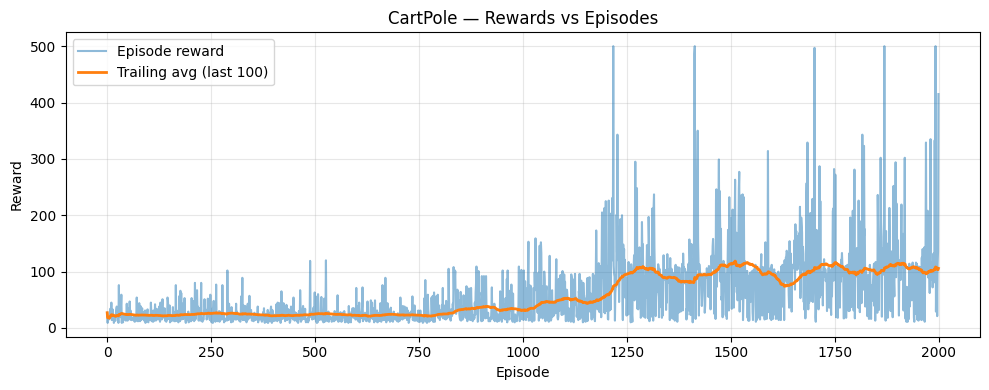

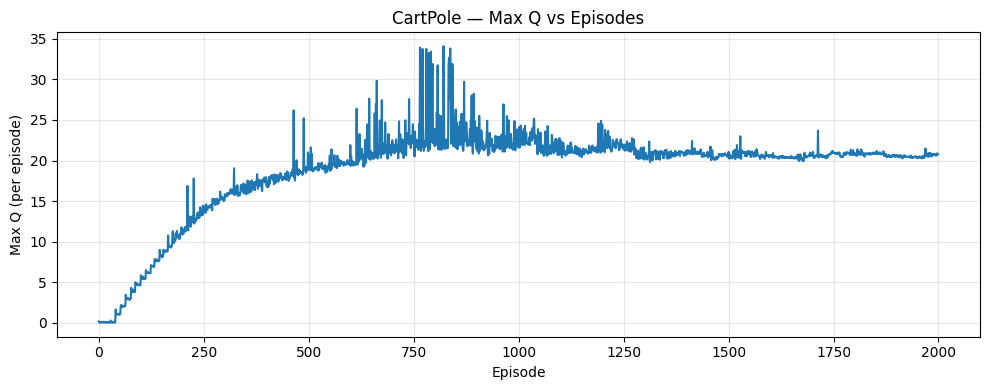

In [32]:
# cell 9
def plot_rewards_series(rewards, out_path, window=100):
    rewards = np.asarray(rewards, np.float32)
    ma = trailing_ma(rewards, k=window)  # trailing, not centered
    plt.figure(figsize=(10,4))
    plt.plot(rewards, label="Episode reward", alpha=0.5)
    plt.plot(ma, label=f"Trailing avg (last {window})", linewidth=2)
    plt.xlabel("Episode"); plt.ylabel("Reward")
    plt.title("CartPole — Rewards vs Episodes")
    plt.legend(); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(out_path, dpi=140); plt.show()

def plot_max_q_series(max_qs, out_path):
    max_qs = np.asarray(max_qs, np.float32)
    plt.figure(figsize=(10,4))
    plt.plot(max_qs)
    plt.xlabel("Episode"); plt.ylabel("Max Q (per episode)")
    plt.title("CartPole — Max Q vs Episodes")
    plt.grid(alpha=0.3)
    plt.tight_layout(); plt.savefig(out_path, dpi=140); plt.show()

plot_rewards_series(rewards, Path(RUN_DIR) / "rewards_vs_episodes.png", window=100)
plot_max_q_series(max_qs, Path(RUN_DIR) / "max_q_vs_episodes.png")

CartPole 500-episode evaluation — Mean = 500.00, Std = 0.00


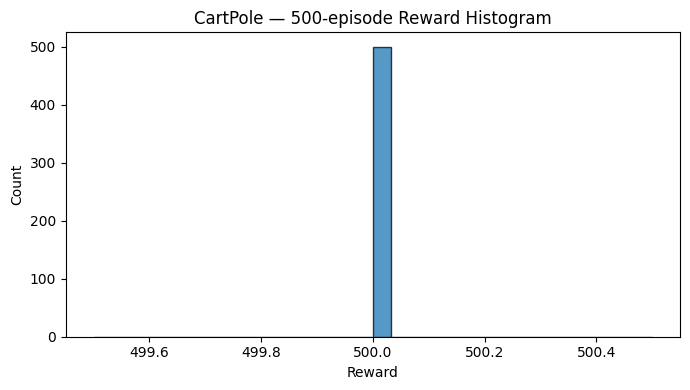

Artifacts saved in: outputs/cartpole_20251105_131600 | checkpoint used: solved.pt


In [33]:
# cell 10
# Load best checkpoint + its normalization stats
ckpt_solved = Path(RUN_DIR) / "solved.pt"
ckpt_best   = Path(RUN_DIR) / "best.pt"
ckpt_path   = ckpt_solved if ckpt_solved.exists() else ckpt_best
stats_path  = Path(RUN_DIR) / "obs_stats.npz"

# Fallback: if no checkpoint (e.g., very short runs), use current net and identity stats
if ckpt_path.exists():
    agent.q.load_state_dict(torch.load(ckpt_path, map_location="cpu"))
    agent.q.eval()
    ckpt_used = ckpt_path.name
else:
    print("WARNING: best/solved checkpoint not found; evaluating current network.")
    ckpt_used = "current_weights"

if stats_path.exists():
    stats = np.load(stats_path)
    mean, std = stats["mean"], stats["std"]
else:
    print("WARNING: obs_stats.npz not found; using no normalization for eval.")
    mean, std = None, None

def norm_obs_eval(x):
    x = x.astype(np.float32)
    if mean is None or std is None:
        return x
    return (x - mean) / (std + 1e-8)

# 500-episode greedy evaluation
eval_rewards = []
for _ in range(500):
    s, info = test_env.reset()
    done, ep_r, steps = False, 0.0, 0
    while not done and steps < MAX_STEPS:
        s_t = torch.as_tensor(norm_obs_eval(np.asarray(s, np.float32)),
                              dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            a = int(torch.argmax(agent.q(s_t), dim=1).item())
        s, r, terminated, truncated, info = test_env.step(a)
        done = terminated or truncated
        ep_r += float(r)
        steps += 1
    eval_rewards.append(ep_r)

eval_rewards = np.asarray(eval_rewards, np.float32)
mean_r, std_r = float(eval_rewards.mean()), float(eval_rewards.std())
print(f"CartPole 500-episode evaluation — Mean = {mean_r:.2f}, Std = {std_r:.2f}")

# Save histogram + stats
plt.figure(figsize=(7,4))
plt.hist(eval_rewards, bins=30, edgecolor="black", alpha=0.75)
plt.xlabel("Reward"); plt.ylabel("Count")
plt.title("CartPole — 500-episode Reward Histogram")
plt.tight_layout()
plt.savefig(Path(RUN_DIR) / "eval_hist_500.png", dpi=140)
plt.show()

with open(Path(RUN_DIR) / "eval_stats.json", "w") as f:
    json.dump({"mean": mean_r, "std": std_r, "checkpoint_used": ckpt_used}, f, indent=2)

print("Artifacts saved in:", RUN_DIR, "| checkpoint used:", ckpt_used)

In [34]:
# cell 11
# Optional sanity run to visually confirm behavior (no rendering to keep it CPU-friendly)
s, info = test_env.reset()
done, ep_r, steps = False, 0.0, 0
while not done and steps < MAX_STEPS:
    s_t = torch.as_tensor(norm_obs_eval(np.asarray(s, np.float32)),
                          dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        a = int(torch.argmax(agent.q(s_t), dim=1).item())
    s, r, terminated, truncated, info = test_env.step(a)
    done = terminated or truncated
    ep_r += float(r)
    steps += 1
print(f"(Optional) single greedy episode reward: {ep_r:.1f}, steps: {steps}")

(Optional) single greedy episode reward: 500.0, steps: 500


# Report - Cartpole

## Techniques Used to Improve Performance

To train the DQN agent on CartPole-v1, several stability and performance enhancements were implemented while staying within the constraints of the assignment (γ = 0.95):
1.	Double DQN Update:
A Double DQN target was used to reduce overestimation bias by decoupling the action selection (from the online network) and target value computation (from the target network). This stabilizes learning and prevents Q-values from diverging.

2. Observation Normalization:
A running mean and standard deviation were maintained for the environment’s four-dimensional state vector. Each observation was normalized before being passed into the network. This ensures that features with different scales are balanced and helps the neural network generalize more smoothly.

3. Multiple Gradient Updates per Step:
Two gradient update steps were performed per environment step once the replay buffer warmed up. This improved sample efficiency without destabilizing learning.

4. Huber Loss and Gradient Clipping:
The Smooth L1 (Huber) loss was used instead of mean squared error to make training robust to outliers in the target Q-values. Gradients were clipped to a norm of 10 to prevent instability due to large parameter updates.

5. get Network Synchronization:
The target network parameters were periodically updated every 500 training steps to stabilize the bootstrap targets used in Q-learning.

6. Greedy Exploration with Decay:
The exploration rate (ε) decayed linearly from 1.0 to 0.05 over 800 episodes. This allowed the agent to explore sufficiently early on and exploit learned policies later.

## Explanation of Plots

1. Rewards vs. Episodes
The reward plot (Figure 1) shows individual episode rewards in blue and a trailing 100-episode moving average in orange. Early in training, rewards remain low due to high exploration and unstable Q-values. Over time, the moving average increases steadily as the agent learns to balance the pole longer. By around episode 1200, the moving average stabilizes and individual spikes reach the maximum reward of 500 steps, satisfying the assignment’s definition of “solved.”

2. Max Q-Value vs. Episodes
Figure 2 plots the maximum predicted Q-value per episode. The steady rise in Q-values during the early episodes indicates that the network is learning a consistent value scale. The plateau that follows reflects convergence—action-value estimates have stabilized and the agent’s confidence in its learned policy is no longer increasing erratically.

3. 500-Episode Evaluation Histogram
Figure 3 presents the reward distribution over 500 greedy (ε = 0) evaluation episodes. Every episode reached the maximum duration of 500 steps, resulting in a single spike at 500 on the histogram (mean = 500.0, std = 0.0). This outcome demonstrates a perfectly solved policy: the agent balances the pole indefinitely until the environment’s time limit is reached.


## Discussion

The combination of Double DQN targets, normalized observations, and stable training mechanisms produced a robust and high-performing model. Although the training curve still shows noise due to ongoing exploration, the greedy evaluation confirms that the final policy is optimal. The uniform histogram is not an anomaly. It signifies a deterministic, fully converged solution to the CartPole task.